<center><h1> Spatial-Statistics Analysis of Visium Colon Data Using Voyagerpy </h1>

In this notebook, we perform spatial-statistics analysis using Voyagerpy on Visium Colon data. The first part follows the Voyagerpy online example, where a KNN distance matrix is regenerated on a downsampled Anndata set. In the second part, the KNN distance matrix is loaded from the rapids-singlecell component, where downsampling is also applied, and the weight matrix is calculated using the PySAL library.

<center>KNN Distance Matrix Generation for Downsampled Anndata Set

In [1]:
import cupy as cp
import cupyx
import scanpy as sc
import scanpy as sc
import numpy as np
from cupyx.scipy.sparse import csr_matrix
import os
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import random
import pandas as pd
import voyagerpy as vp
import geopandas as gpd
import libpysal as lps
from collections import OrderedDict
import scipy.sparse as sp
import pickle

In [ ]:
path_016 = "/data/kanferg/Sptial_Omics/playGround/Data/Visium_HD_Human_Colon_Cancer_binned_outputs/binned_outputs/square_016um"
pathout = "/data/kanferg/Sptial_Omics/SpatialOmicsToolkit/out_2"
andata = sc.read_h5ad(os.path.join(pathout, "andata_save_colon.h5ad"))
andata.uns['config'] = OrderedDict()
andata.uns['config'] = OrderedDict()
andata.uns["config"]["secondary_var_names"] = andata.var_names

import os
import pickle

file_path = os.path.join(pathout, "andata_uns_mtracies__colon.pkl")

if os.path.getsize(file_path) > 0:
    with open(file_path, 'rb') as buff:
        andata_uns_mtracies = pickle.load(buff)
else:
    print("File is empty. Cannot load data.")
    andata_uns_mtracies = None

In [ ]:
andata.uns['clusterColorMap'] = andata_uns_mtracies['clusterColorMap']
andata.uns['rank_genes_groups'] = andata_uns_mtracies['rank_genes_groups']

In [ ]:
from scipy.sparse import csr_matrix
andata_sub = andata.copy()
andata_sub.X = csr_matrix(andata_sub.X)
andata_sub = sc.pp.subsample(andata_sub, n_obs=7000,copy=True)

In [ ]:
# andata_sub.obs.index = np.arange(len(andata_sub.obs.index))
# andata_sub.obs_names = andata_sub.obs_names.astype(str)
scale = 1
visium_spots = gpd.GeoSeries.from_xy(andata_sub.obsm['spatial'][:,0], andata_sub.obsm['spatial'][:,1]).scale(scale, scale, origin=(0, 0))
_ = vp.spatial.set_geometry(andata_sub, geom="spot_poly", values=visium_spots)

In [ ]:
andata_sub.X = andata_sub.layers['log']
sc.pp.scale(andata_sub, max_value=10)

In [ ]:
sc.pp.pca(andata_sub, n_comps=15)

In [ ]:
sc.pp.neighbors(
    andata_sub,
    n_neighbors=25,
    n_pcs=15,
    use_rep='X_pca',
    knn=True,
    random_state=29403943,
    method='umap', # one of umap, gauss, rapids
    metric='cosine', # many metrics available,
    key_added='knn'
)

In [ ]:
sparse_dist_matrix = andata_sub.obsp['knn_distances'].tocsr()
sparse_inv_matrix = sparse_dist_matrix.copy()
sparse_inv_matrix.data = 1 / sparse_inv_matrix.data
sparse_inv_matrix.data[sparse_inv_matrix.data == float('inf')] = 0
# Convert the sparse matrix to COOrdinate format
sparse_inv_matrix_coo = sparse_inv_matrix.tocoo()

# Extract the row (focal) and column (neighbor) indices of non-zero entries
focal = sparse_inv_matrix_coo.row
neighbors = sparse_inv_matrix_coo.col

# focal = focal.get()
# neighbors = neighbors.get() 

idx = np.array(andata.obs_names,dtype=str) # Assuming this is a pandas Index or a list-like structure

# Convert sparse matrix values to a 1D array explicitly
weights = sparse_inv_matrix_coo.data
# weights = weights.get()



# Create a DataFrame with focal, neighbor, and weight information
graph_df = pd.DataFrame({
    "focal": idx[focal],
    "neighbor": idx[neighbors],
    "weight": weights  # The actual non-zero values (inverted distances)
})

# Display the DataFrame to check
graph_df.head()

graph_df_filtered = graph_df[graph_df['weight'] != 0]

In [ ]:
W = lps.weights.W.from_adjlist(graph_df_filtered)
W.set_transform("r")

In [ ]:
andata_sub.obsp["knn_weights"] = sparse_inv_matrix

In [ ]:
vp.spatial.set_default_graph(andata_sub, "knn_weights")

In [ ]:
andata_sub.uns.setdefault("spatial", {})
andata_sub.uns["spatial"]["knn_weights"] = W

In [ ]:
qc_features = ["total_counts"]
morans = vp.spatial.moran(andata_sub, qc_features, graph_name="knn_weights")
andata_sub.uns['spatial']['moran']["knn_weights"].loc[qc_features, ["I"]]

In [ ]:
vp.spatial.compute_spatial_lag(
    andata_sub,
    qc_features,
    graph_name="knn_weights",
    inplace=True
)

In [ ]:
ax = vp.plt.moran_plot(andata_sub, feature="total_counts", color_by='cluster', alpha=0.8,s = 3)

In [ ]:
andata_sub

In [ ]:
andata_sub.obs['lagged_total_counts']

In [ ]:
ax = vp.plt.moran_plot(andata, feature="total_counts", color_by='cluster', alpha=0.8,s = 1)

<center> Loading Precomputed KNN Distance Matrix and Weight Calculation Using PySAL" </center>

In [2]:
path_016 = "/data/kanferg/Sptial_Omics/playGround/Data/Visium_HD_Human_Colon_Cancer_binned_outputs/binned_outputs/square_016um"
pathout = "/data/kanferg/Sptial_Omics/SpatialOmicsToolkit/out_2"
andata = sc.read_h5ad(os.path.join(pathout, "andata_save_colon.h5ad"))
andata.uns['config'] = OrderedDict()
andata.uns['config'] = OrderedDict()
andata.uns["config"]["secondary_var_names"] = andata.var_names
def load_matrix(andata,pathout,npz_file = "obsp_distances.npz",mode = 'sparse', mat_name = 'distances'):
    npzfile = cp.load(os.path.join(pathout, npz_file))
    data = cp.array(npzfile['data'])
    indices = cp.array(npzfile['indices'])
    indptr = cp.array(npzfile['indptr'])
    shape = tuple(npzfile['shape'])
    
    # Reconstruct the sparse matrix
    sparse_matrix_distances = csr_matrix((data, indices, indptr), shape=shape)
    if mode== 'sparse':
        andata.obsp[mat_name] = sparse_matrix_distances
    else:
        andata.obsp[mat_name] = sparse_matrix_distances.get()
    return andata
andata = load_matrix(andata,pathout,npz_file = "obsp_distances_large_colon.npz",mode = 'cupyx', mat_name = 'distances')
andata = load_matrix(andata,pathout,npz_file = "obsp_connectivities_large_colon.npz",mode = 'cupyx', mat_name = 'connectivities')
andata

AnnData object with n_obs × n_vars = 133282 × 1500
    obs: 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_MT', 'pct_counts_MT', 'log1p_total_counts_MT', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'MT', 'n_cells_by_counts', 'total_counts', 'mean_counts', 'pct_dropout_by_counts', 'log1p_total_counts', 'log1p_mean_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'config'
    obsm: 'X_pca', 'spatial'
    layers: 'counts', 'log'
    obsp: 'distances', 'connectivities'

Loding gene expression level data

In [ ]:
with open(os.path.join(pathout,"andata_uns_mtracies__colon.pkl"), 'rb') as buff:
    andata_uns_mtracies__colon = pickle.load(buff)
andata.uns['rank_genes_groups'] = andata_uns_mtracies__colon['rank_genes_groups']
del andata_uns_mtracies__colon
with open(os.path.join(pathout,"stlearn_uns_mtracies_colon.pkl"), 'rb') as buff:
    stlearn_uns_mtracies_colon = pickle.load(buff)
andata.uns['lrfeatures'] = stlearn_uns_mtracies_colon['lrfeatures']
andata.uns['lr_summary'] = stlearn_uns_mtracies_colon['lr_summary']
del stlearn_uns_mtracies_colon
with open(os.path.join(pathout,"stlearn_obsm_mtracies_colon.pkl"), 'rb') as buff:
    stlearn_obsm_mtracies_colon = pickle.load(buff)
andata.obsm['spot_neighbours'] = stlearn_obsm_mtracies_colon['spot_neighbours']
andata.obsm['spot_neigh_bcs'] = stlearn_obsm_mtracies_colon['spot_neigh_bcs']
andata.obsm['lr_scores'] = stlearn_obsm_mtracies_colon['lr_scores']
andata.obsm['p_vals'] = stlearn_obsm_mtracies_colon['spot_neigh_bcs']
andata.obsm['-log10(p_adjs)'] = stlearn_obsm_mtracies_colon['-log10(p_adjs)']
andata.obsm['lr_sig_scores'] = stlearn_obsm_mtracies_colon['lr_sig_scores']
del stlearn_obsm_mtracies_colon

Downsample anndata including distance and connectivity matrix

In [3]:
from scipy.sparse import csr_matrix
andata_sub = andata.copy()
andata_sub.X = csr_matrix(andata_sub.X)
andata_sub = sc.pp.subsample(andata_sub, n_obs=100_000,copy=True)

Switch sparse matrix to cupyx sparse matrix 

In [4]:
from cupyx.scipy.sparse import csr_matrix
andata_sub.obsp['distances'] = csr_matrix(andata_sub.obsp['distances'])
andata_sub.obsp['distances'] = csr_matrix(andata_sub.obsp['connectivities'])

Distance matrix preparation for weights matrix by inverse (1 over distance matrix). Important to note that one working with sparse matrix one can do 1/sparse since it contains only the non-zero values.

In [5]:
import scipy.sparse as sp
sparse_dist_matrix = andata_sub.obsp['distances'].tocsr()
sparse_inv_matrix = sparse_dist_matrix.copy()
sparse_inv_matrix.data = 1 / sparse_inv_matrix.data
sparse_inv_matrix.data[sparse_inv_matrix.data == float('inf')] = 0

In [6]:
# Convert the sparse matrix to COOrdinate format
sparse_inv_matrix_coo = sparse_inv_matrix.tocoo()

# Extract the row (focal) and column (neighbor) indices of non-zero entries
focal = sparse_inv_matrix_coo.row
neighbors = sparse_inv_matrix_coo.col

focal = focal.get()
neighbors = neighbors.get() 

idx = np.array(andata_sub.obs_names,dtype=str) # Assuming this is a pandas Index or a list-like structure

# Convert sparse matrix values to a 1D array explicitly
weights = sparse_inv_matrix_coo.data
weights = weights.get()


# Create a DataFrame with focal, neighbor, and weight information
graph_df = pd.DataFrame({
    "focal": idx[focal],
    "neighbor": idx[neighbors],
    "weight": weights  # The actual non-zero values (inverted distances)
})

# Display the DataFrame to check
graph_df.head()

graph_df_filtered = graph_df[graph_df['weight'] != 0]

The data frame is composed of, focal, neighbors and weight columns.  Remove all the disconnected neighbors.  

In [ ]:
graph_df_filtered = graph_df[graph_df['weight'] != 0]

neighbor_counts = graph_df_filtered.groupby("focal")["neighbor"].count()
# Identify connected nodes (nodes with at least 2 neighbor)
connected_nodes = neighbor_counts[neighbor_counts > 3].index
# Filter graph_df to keep only connected nodes
graph_df_filtered = graph_df_filtered[graph_df_filtered['focal'].isin(connected_nodes)]

In [7]:
W = lps.weights.W.from_adjlist(graph_df_filtered)
W.set_transform("r")

In [12]:
knn_graph = "knn_weights"
andata_sub.obsp["knn_weights"] = sparse_inv_matrix.get()

andata_sub.uns.setdefault("spatial", {})
andata_sub.uns["spatial"][knn_graph] = W

Global morans-I measurement on the level library depth level.

In [13]:
qc_features = ["total_counts"]
morans = vp.spatial.moran(andata_sub, qc_features, graph_name=knn_graph)
andata_sub.uns['spatial']['moran'][knn_graph].loc[qc_features, ["I"]]

,I
total_counts,-0.001476


In [14]:
andata_sub.obsp["knn_weights"]

<100000x100000 sparse matrix of type '<class 'numpy.float32'>'
	with 2750100 stored elements in Compressed Sparse Row format>

In [16]:
andata_sub

AnnData object with n_obs × n_vars = 100000 × 1500
    obs: 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_MT', 'pct_counts_MT', 'log1p_total_counts_MT', 'cluster', 'lagged_total_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'MT', 'n_cells_by_counts', 'total_counts', 'mean_counts', 'pct_dropout_by_counts', 'log1p_total_counts', 'log1p_mean_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'config', 'spatial'
    obsm: 'X_pca', 'spatial'
    layers: 'counts', 'log'
    obsp: 'distances', 'connectivities', 'knn_weights'

In [24]:
ylag = lps.weights.lag_spatial(W, andata_sub.obs['total_counts'].values)
andata_sub.obs['lagged_total_counts'] = lps.weights.lag_spatial(W, andata_sub.obs['total_counts'].values)

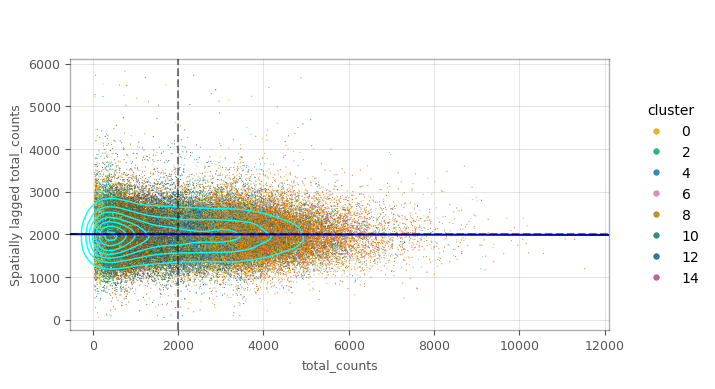

In [26]:
ax = vp.plt.moran_plot(andata_sub, feature="total_counts", color_by='cluster', alpha=0.8,s = 0.1)

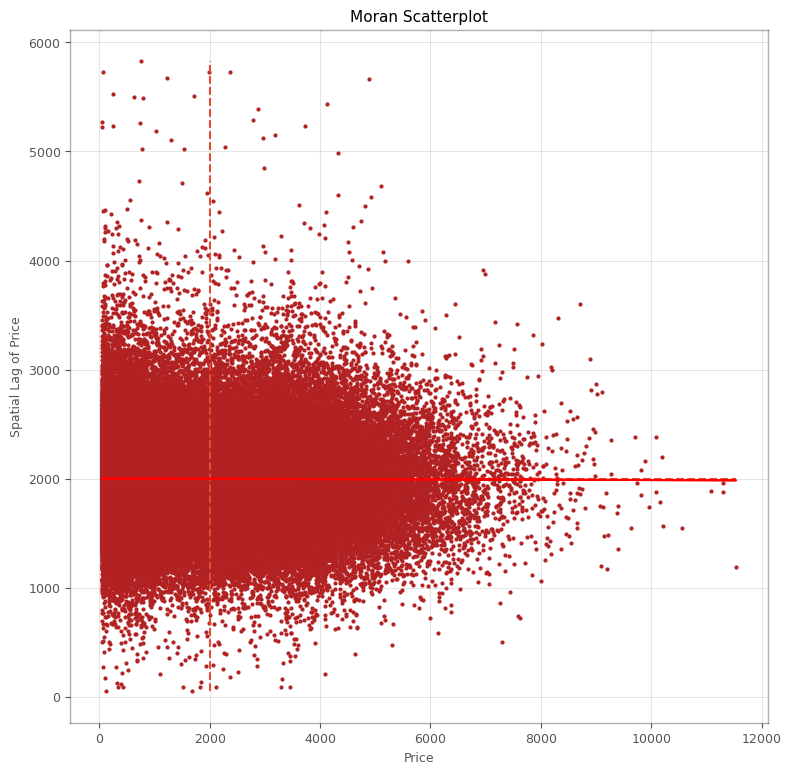

In [30]:
total_count = andata_sub.obs['total_counts'].values
lagged_total_counts = andata_sub.obs['lagged_total_counts'].values
b, a = np.polyfit(total_count, lagged_total_counts, 1)
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(total_count, lagged_total_counts, '.', color='firebrick')

 # dashed vert at mean of the price
plt.vlines(total_count.mean(), lagged_total_counts.min(), lagged_total_counts.max(), linestyle='--')
 # dashed horizontal at mean of lagged price
plt.hlines(lagged_total_counts.mean(), total_count.min(), total_count.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(total_count, a + b*total_count, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Price')
plt.xlabel('Price')
plt.show()

In [27]:
_ = vp.spatial.local_moran(andata_sub, qc_features, graph_name=knn_graph)

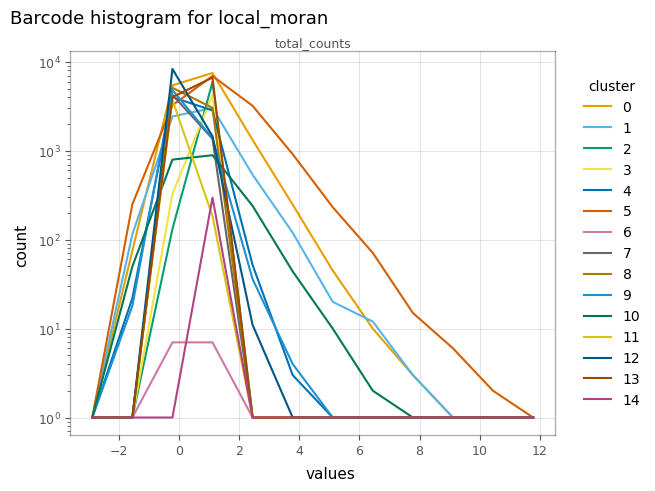

In [28]:
axs = vp.plt.plot_barcode_histogram(
    andata_sub,
    qc_features,
    obsm="local_moran",
    color_by='cluster',
    log=True,
    histtype='line',
    bins=10,
)

Gene expression level local morna-I analysis

In [ ]:
hvg = andata_sub.var[andata_sub.var['highly_variable'].values].index
vp.spatial.moran(andata_sub, feature=hvg, dim='var', graph_name=knn_graph)

In [ ]:
hvgs_moransI = andata_sub.uns['spatial']['moran'][knn_graph].loc[hvg, 'I']
andata_sub.var.loc[hvg, "moran"] = hvgs_moransI
andata_sub.var.loc[:, ["moran"]] = np.nan_to_num(andata_sub.var.loc[:, ["moran"]],0.0)
mat_names = np.ravel(pd.DataFrame(andata_sub.uns['rank_genes_groups']['names']).values)
marker_genes = mat_names[:20].tolist()
andata_sub.var['symbol'] = andata_sub.var['gene_ids'].values

In [ ]:
with PdfPages(os.path.join(pathout, 'plot_features_histogram_marker_genes_colon.pdf')) as pdf:
    _ = vp.plt.plot_features_histogram(
        andata_sub,
        "moran",
        bins=50,
        log=False,
        histtype="bar",
        markers=marker_genes,
        show_symbol=False)
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2)
    pdf.savefig()
    plt.close()

In [ ]:
cluster_num = len(np.unique(andata_sub.obs['cluster'].values))
_ = vp.spatial.local_moran(andata_sub, marker_genes, graph_name=knn_graph)
marker_genes_symbols = andata_sub.var.loc[marker_genes, "symbol"].tolist()

In [ ]:
with PdfPages(os.path.join(pathout, 'plot_barcode_histogram_marker_genes_colon.pdf')) as pdf:
    _ = vp.plt.plot_barcode_histogram(
        andata_sub,
        marker_genes,
        color_by='cluster',
        obsm='local_moran',
        histtype='line',
        figsize=(15,15),
        subplot_kwargs=dict(layout='constrained'),
        label=marker_genes,
        ncol=2
    )
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2)
    pdf.savefig()
    plt.close()